In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from collections import Counter
import re
from time import sleep
import pandas as pd

In [ ]:
def text_cleaner(text_url):
    headers = requests.utils.default_headers()
    headers.update(
        {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
        }
    )
    txtpg_response = requests.get(text_url, headers=headers)
    page_soup=BeautifulSoup(txtpg_response.text, 'html.parser')
    for script in page_soup(["style", "script"]):
        script.extract()
    text = page_soup.get_text()
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    def chunk_space(chunk):
        chunk_out = chunk + ' '
        return chunk_out      
    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8')
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') 
    except:                                                            
        return
    text = re.sub(b"[^a-zA-Z.+3]",b" ", text)
    text = text.lower().decode("utf-8").split()
    text = list(set(text))
    return text

In [ ]:
def postings_for_location(keyword, location):
    base_url="http://www.monster.ca/jobs/search/"
    paramslist={'q': keyword, 'where': location}
    job_postings=[]
    headers = requests.utils.default_headers()
    headers.update(
        {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
        }
    )

    response = requests.get(base_url, params=paramslist, headers = headers)
    while (response):
        print("collecting information from:" + response.url)
        soup = BeautifulSoup(response.text, 'html.parser')
        nextpage_results= soup.select('link[rel=next]')
        if nextpage_results:
            response = requests.get(nextpage_results[0]['href'], headers=headers)
        else:
            response=""

        all_rows = soup.select('div[class="jobTitle"] a')
        for row in all_rows:
            link = row["href"]
            print(link)
            job_postings.append(text_cleaner(link))
        sleep(2)
    return job_postings

In [ ]:
def raw_postings(keyword, location):
    base_url="https://www.monster.com/jobs/search/"
    paramslist={'q': keyword, 'where': location}
    job_postings=[]
    headers = requests.utils.default_headers()
    headers.update(
        {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
        }
    )

    response = requests.get(base_url, params=paramslist, headers = headers)
    while (response):
        print("collecting information from:" + response.url)
        soup = BeautifulSoup(response.text, 'html.parser')
        nextpage_results= soup.select('link[rel=next]')
        if nextpage_results:
            response = requests.get(nextpage_results[0]['href'], headers=headers)
        else:
            response=""

        all_rows = soup.select('div[class="jobTitle"] a')
        for row in all_rows:
            try:
                link = row["href"]
                print (link)
                post_text=",".join(text_cleaner(link))
                job_postings.append((keyword, location, link, post_text))
            except:
                continue
        sleep(2)
    df = pd.DataFrame.from_records(job_postings, columns=["keyword", "location", "link", "post_text"])
    return df

In [ ]:
toronto_postings = raw_postings("Software-Development", 'Toronto,-Ontario')

In [ ]:
toronto_postings.to_csv(r"D:\monster_scrapingdata\softdev_to_20170116.csv", sep='\t', encoding='utf-8')

In [ ]:
toronto_postings.shape

In [ ]:
mtl_postings = raw_postings("Software-Development", 'Montreal,-QC')

In [ ]:
mtl_postings.to_csv(r"D:\monster_scrapingdata\softdev_mtl_20170116.csv", sep='\t', encoding='utf-8')

In [ ]:
Vancouver_postings= raw_postings("Software-Development", 'Vancouver,-BC')

In [ ]:
Vancouver_postings.to_csv(r"D:\monster_scrapingdata\softdev_vcv_20170116.csv", sep='\t', encoding='utf-8')

In [ ]:
Waterloo_postings = raw_postings("Software-Development", 'Waterloo,-Ontario')

In [ ]:
Waterloo_postings.to_csv(r"D:\monster_scrapingdata\softdev_wtl_20170116.csv", sep='\t', encoding='utf-8')

In [ ]:
import sys
location_list=["New-York_NY", "Boston_MA", "Washington_DC", "Seattle_WA", "San-Francisco_CA", "Austin_TX", 
               "San-Jose_CA", "Raleigh_NC", "Houston_TX", "Portland_OR", "Atlanta_GA", "San-Diego_CA", "Denver_CO", 
               "Minneapolis_MN", "Saint-Louis_MO"]
for location in location_list:
    print ("start location %s" %location)
    try:
        location_postings = raw_postings("Software-Development", location)
        location_postings.to_csv(r"D:\monster_scrapingdata\softdev_" + location +"_20170116.csv", sep='\t', encoding='utf-8')
    except Exception as e:
        print ("fail %s" %location)
        print(sys.exc_info()[0])
    sleep(300)

In [119]:
techlist=["javascript","sql", 'java', 'c#', 'php', 'c++', 'c', 'node.js', 'angularjs', 'ruby', 'rails', 'python', 
          'delphi', 'typescript', 'bash', 'groovy', 'powershell', 'html', 'css', 'django','postgresql', 'jquery', 'ios', 'git', 
          'mysql', '.net', 'arrays', 'swift', 'objective-c', 'string', 'json', 'sql server', 'linux', 'regex', 'asp.net' 
         'react', 'spark', 'cassandra', 'raspberry pi', 'wordpress', 'mongodb', 'redis', 'vba', 'hadoop', 'clojure'
         'go', 'f#', 'sharepoint', 'rust', 'scala', 'count', 'cordova', 'perl', 'salesforce', 'matlab', 'dart', 'coffeescript',
         'haskell', 'windows phone', 'aws', 'gae', 'azure', 'lamp']

def build_dic(postings):
    techdic={}
    for tech in techlist:
        techdic[tech] = 0

    for jobtech in postings:
        for tech in techlist:
            if bytearray(tech, "ascii") in jobtech:
                techdic[tech] += 1
    return techdic

In [ ]:
toronto_dic = build_dic(toronto_postings)

In [ ]:
mtl_dic = build_dic(mtl_postings)

In [ ]:
chart(toronto_dic, "Toronto")

In [ ]:
chart(mtl_dic, "Montreal")

In [1]:
%load_ext sql

In [2]:
%sql sqlite://

'Connected: None@None'

In [4]:
## Load csv files into SQL via pandas ##
import pandas as pd
location_list=["Toronto_ON", "Montreal_QC", "Vancouver_BC", "Waterloo_ON", "New-York_NY", "Boston_MA", "Washington_DC", 
               "Seattle_WA", "San-Francisco_CA", "Austin_TX", "San-Jose_CA", "Raleigh_NC", "Houston_TX", "Portland_OR", 
               "Atlanta_GA", "San-Diego_CA", "Denver_CO", "Minneapolis_MN", "Saint-Louis_MO"]
%sql DROP TABLE IF EXISTS ALLPOST
%sql CREATE TABLE ALLPOST (keyword varchar, location varchar, link varchar, post_text varchar)
for location in location_list:
    df = pd.read_csv("D:\monster_scrapingdata\softdev_" + location + "_20170116.csv", sep='\t', header=0, index_col=0)
    %sql DROP TABLE IF EXISTS df
    %sql PERSIST df
    %sql INSERT INTO ALLPOST SELECT keyword, location, link, post_text FROM df 

Done.
Done.
Done.
1000 rows affected.
Done.
1000 rows affected.
Done.
1000 rows affected.
Done.
579 rows affected.
Done.
977 rows affected.
Done.
975 rows affected.
Done.
980 rows affected.
Done.
979 rows affected.
Done.
980 rows affected.
Done.
980 rows affected.
Done.
979 rows affected.
Done.
980 rows affected.
Done.
975 rows affected.
Done.
980 rows affected.
Done.
976 rows affected.
Done.
980 rows affected.
Done.
973 rows affected.
Done.
975 rows affected.
Done.
979 rows affected.
Done.


keyword,location,link,post_text
Software-Development,"Toronto,-Ontario",http://jobview.monster.ca/software-development-manager-job-toronto-on-ca-179262760.aspx?mescoid=1100011001001&jobPosition=1,"monster,notified,distributed,free,quality,drive,by,technologies,position.,developer,this,nodejs,that,discipline,combined,mongo,technical,strategic,mentoring,less,new,dependencies,market,no.,authorized,leadership,productivity,apply,track,job.,understanding,sprint,both,experience,using,fosters,easily,experienced,planning,estimating,get,plus,angularjs,worldwide,in,environment.,pluses,guide,structures,main,at,provide,lifecycle,privacy,flexible,of,hide,addressed,name,posted,used,s,jira,standards,repeatable,content,tier,find,and,inc,enforce,db,key,product,previous,timely,achieve,architecture,eligible,tools.,monster.com,level,close,fri,type,coaching,policy,cassandra,criteria,sustainable,applications,view,from,industries,program,addresses,selected,couch,innovative,submit,knowledge,java,code,development,production,offering,software,computer,use,reviews,position,create,through,managed,continuing,ios,kitchen,e.g.,company,ensure,propose,toronto,team,features,providing,passionate,updated,not,functional,modern,considered,about,engineer,agile,any,communication,complex,edge,kanban,marketing,improvements,fashion,nosql,bridges,technology,axosoft,canada.,terms,packaging,enhance,json,applicants,delivery,techniques,their,b,define,entire,who,regular,players,breakdown,fast,ll,the,.,android,v,you,while,be,processes,mitigated,javascript,strong,employee,working,search,subscribe,pop,oral,starter,approaches,devops,today,with,feedback,skills.,multi,patents,agree,budget,similar,delivered,mobile,digital,scrum,manage,improve,stocked,to,address,infrastructureexperience,33,info,my,ideal,copyright,members,rest,business,web,xprogramming,career,are,all,versionone,incidents,design,excellent,a,transcoding,services,location,cohesive,or,they,champion,job,role,prior,must,our,stated,cloud,summary,full,understand,considerations,goals,non,skip,has,environment,performance,record,cutting,necessary,manager,maintaining,build,encryption,january,yearly,skills,include,support,teams,site,last,want,exposure,save,conduct,on,report,application,friendly,methodologies,task,associated,like,databases,email,process,organization,self,guiding,deliverables,mail,group,such,reference,as,will,cookies.,progressive,breakfast,paced,for,3,candidate,also,deliver,deliverablesrequired,xml,more,can,across,output,only,video,tdd,work,ensuring,tal,creativity,relational,management,minimum,cross,note,proven,hiring,years,environment.perks,fully,refine,within,time,snacks,jobs,written,u.s.,including,love,ui,tools,sr.,vibrant,meeting,efficiency,hoursin"
Software-Development,"Toronto,-Ontario",http://jobview.monster.ca/software-development-manager-job-toronto-on-ca-179115106.aspx?mescoid=1100011001001&jobPosition=1,"monster,distributed,around,versiononeprevious,quality,drive,by,technologies,this,that,discipline,combined,mongo,technical,strategic,days,less,new,operators,dependencies,market,lifecycle.propose,commercial,no.,leadership,productivity,apply,track,job.,understanding,sprint,both,using,experience,fosters,easily,providers,planning,estimating,get,worldwide,videos,in,details,environment.,pluses,guide,structures,main,at,provide,lifecycle,privacy,flexible,benefits,of,hide,tv,addressed,streaming,high,name,used,s,jira,offeringcreate,standards,repeatable,content,grow,tier,plusknowledge,find,and,enforce,db,recognized,key,product,achieve,timedo,timely,architecture,level,bay,monster.com,close,type,coaching,policy,cassandra,view,sustainable,applications,addresses,industries,selected,couch,3k,innovative,submit,knowledge,java,senior,development,production,software,computer,use,reviews,create,through,managed,continuing,your,ios,e.g.,company,ensure,toronto,team,features,providing,passionate,not,functional,modern,about,agile,communication,helena,m,complex,kanban,tools.create,improvements,fashion,nosql,bridges,axosoft,terms,pac

In [5]:
%sql SELECT COUNT(*) FROM ALLPOST

Done.


COUNT(*)
18247


In [118]:
%sql SELECT Count(*) FROM ALLPOST WHERE location = "Toronto_ON" AND (post_text LIKE "%,c,%" OR post_text LIKE "c,%" OR post_text LIKE "%,c")

Done.


Count(*)
299


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:

def skillchart(dic, title_city):
    df=pd.DataFrame.from_dict(dic, orient='index', dtype=None)
    df.columns=['Percentage']
    df.sort_values(by='Percentage', ascending=False, inplace=True)
    tofig=df[0:20].plot.bar(figsize=(15,8), fontsize=16, color='#A3E4D7')
    tofig.set_title('Key Skills in ' + title_city, fontsize=16, fontweight='bold')

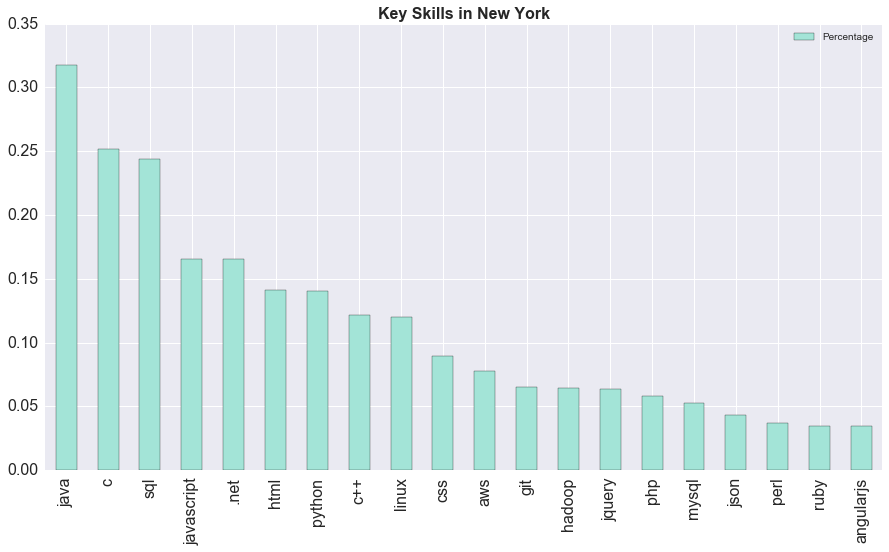

In [137]:
skillchart(skillctdict, "New York")

In [136]:
## Top Skills for a specific city ##
skillctdict={}
for tech in techlist:
    acount=%sql SELECT Count(*) FROM ALLPOST WHERE location = "New-York_NY" AND (post_text LIKE "%,$tech,%" OR post_text LIKE "$tech,%" OR post_text LIKE "%,$tech")
    citycount=%sql SELECT Count(*) FROM ALLPOST WHERE location = "New-York_NY"
    skillctdict[tech]=acount[0][0]/citycount[0][0]    

Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


In [99]:

def citychart(dic, tech_name):
    df=pd.DataFrame.from_dict(dic, orient='index', dtype=None)
    df.columns=['Percentage']
    df.sort_values(by='Percentage', ascending=True, inplace=True)
    tofig=df[0:20].plot.barh(figsize=(15,8), fontsize=16, color='orange')
    tofig.set_title('Popular cities for' + tech_name, fontsize=16, fontweight='bold')

In [132]:
## City Ranking for a specific skill ##
citydict={}
for location in location_list:
    acount=%sql SELECT COUNT(*) FROM ALLPOST WHERE location= :location AND instr(post_text, ",javascript,") >0 
    citycount=%sql SELECT COUNT(*) FROM ALLPOST WHERE location= :location
    if citycount[0][0] != 0:
        citydict[location]=acount[0][0]/citycount[0][0]

Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


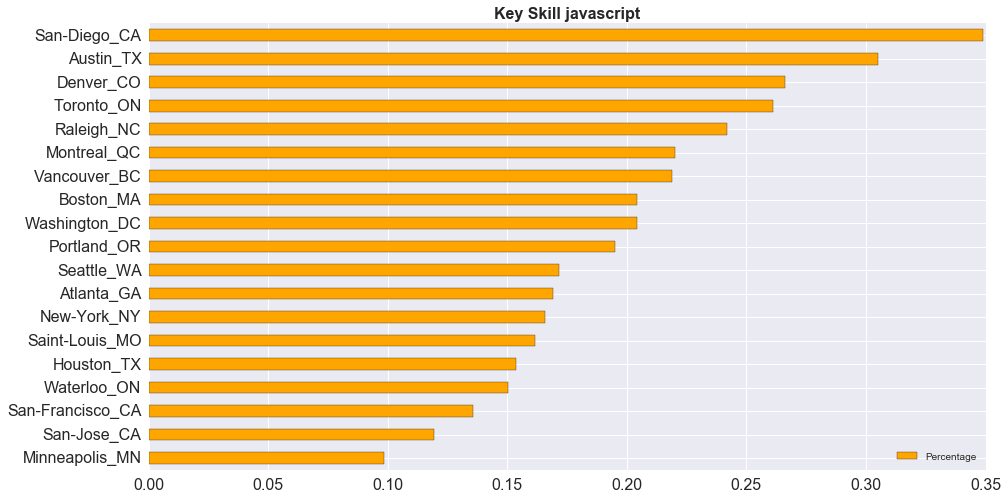

In [133]:
citychart(citydict, "javascript")